# SDSS: Data I/O and Binned Plotting

In this tutorial we will be loading up some SDSS data (mass, metallicity, and star formation rate) for a bunch of galaxies. We will then plot the Mass metallicity relation, and explore it in a bit more depth. 

You can work on this tutorial in anyway you like- You can use this html to copy and paste into your own ipython notebook (or just a python script in a plaintext editor) and then make changes, you can follow along working from scratch, or you can download the .ipynb version of this document from the Tutorials page and work directly in it. 

Let's go ahead and get started with our import statements:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from matplotlib.colors import LogNorm
%matplotlib inline

Great. Now we will want to load the data from the fits files we downloaded. let's define a function that will do this for any fits data table file, and then feed it the three file-names we have. 

In [2]:
def load_fits(fname):
    hdu = pf.open(fname)[1] #why 1? and not like 0?
    data = hdu.data      #accesses the data table
    return data

sfr_full = load_fits('gal_totsfr_dr7_v5_2.fits')
mass_full = load_fits('totlgm_dr7_v5_2b.fit')
z_full = load_fits('gal_fiboh_dr7_v5_2.fits')

We now have three sets of data. Each of our datasets above has multiple columns being stored in what is known as a "record array" (or rec.array). This is a form of array that allows indexing by attribue, much like a dictionary. We can print out what the column names are by using dot notation on our data sets. 

In [3]:
sfr_full.columns
#E means floating point in exponent format
#D means integers
#https://thepythonguru.com/python-string-formatting/

ColDefs(
    name = 'AVG'; format = 'E'
    name = 'ENTROPY'; format = 'D'
    name = 'FLAG'; format = 'E'
    name = 'MEDIAN'; format = 'E'
    name = 'MODE'; format = 'E'
    name = 'P16'; format = 'E'
    name = 'P2P5'; format = 'E'
    name = 'P84'; format = 'E'
    name = 'P97P5'; format = 'E'
)

As we can see, we have columns like "Avg", "Entropy", "Median", "Flag", etc. For the purposes of this tutorial, we are interested in the "Avg column." Like most datasets of real data, not all of the galaxies or entries in these files are usable- generally the pipeline that creates the datasets will "flag" bad data in an easily programmatically removable way. Sometimes it is using a "flag" column, and other times is is by selecting an arbitrary and non-physical number to enter as the value (this is how the SDSS data is handled). The values of the flags can usually be found in a readme file. 

So, we need to restrict our data to just those that don't have any warning flags. In the cell below, (or in your code), find the indices (locations) for which the following conditions are satisfied, and save them to a variable called "restrictions":

1. In the SFR array, the value is > -99
2. In the Mass array, the value is not equal to -1
3. In the metallicity array, the value is > -99.9 

Hint: Do not use a for loop to iterate over the arrays and check the conditions- there is a much faster and more efficient method. 

In [4]:
"""
res_sfr = np.where(sfr_full['AVG'] > -99)
res_mass = np.where(mass_full['AVG'] != -1)
res_z = np.where(z_full['AVG'] > -99.9)
restrictions = np.concatenate((res_sfr, res_mass, res_z), axis=None)
^^doesn't result in the right length? try combining them at once now ->
"""
restrictions = np.where((sfr_full['AVG'] > -99) &
                        (mass_full['AVG'] != -1) &
                        (z_full['AVG'] > -99.9))

Great, so now we know which indices correspond to the data that's actually useable. Out of curiosity, calculate the number of elements this process actually removed below:

In [5]:
print(len(sfr_full['AVG']) - len(restrictions))

927551


Next, we need to actually grab that data (remember, we currently only have the indices). Fill in the rest below

In [6]:
sfr = np.array(sfr_full[restrictions])
mass =np.array(mass_full[restrictions])
z = np.array(z_full[restrictions])
#why no ['AVG'] ?

Note: These arrays (because we are using our full arrays from above), are record arrays containing multiple values for each galaxy. We can print out sfr below to see what that means (you can re-run the cell below to ensure you got the same thing I did): 

In [7]:
sfr

array([( 0.0813901 , -4.4283232 , 0.,  0.04046527,  0.05000019, -0.19248106, -0.4438595 ,  0.30087733,  0.62325597),
       (-0.14585991, -4.36189085, 0., -0.1865475 , -0.25      , -0.40367356, -0.64416677,  0.05915504,  0.39761928),
       (-0.3946299 , -4.45485405, 0., -0.4310218 , -0.5       , -0.6633065 , -0.9434209 , -0.16827413,  0.16142888),
       ...,
       ( 0.22899014, -2.66265069, 2.,  0.19214118,  0.20000029,  0.11597011,  0.02719309,  0.2938598 ,  0.34685245),
       (-2.01222   , -4.88495688, 2., -2.0584905 , -2.        , -2.4491737 , -2.710241  , -1.6       , -1.2664285 ),
       (-0.8014198 , -2.27985398, 2., -0.83019316, -0.7999997 , -0.88976175, -1.0017241 , -0.7295781 , -0.68342847)],
      dtype=(numpy.record, [('AVG', '>f4'), ('ENTROPY', '>f8'), ('FLAG', '>f4'), ('MEDIAN', '>f4'), ('MODE', '>f4'), ('P16', '>f4'), ('P2P5', '>f4'), ('P84', '>f4'), ('P97P5', '>f4')]))

Essentially, sfr is a an array of the same type as the original, only with the bad entries removed. Using the same indexing, create variables sfrs, masses, and metallicities by indexing your sfr, mass, and z arrays for the "AVG" column.

In [8]:
sfrs = np.array(sfr_full['AVG'][restrictions])
masses = np.array(mass_full['AVG'][restrictions])
metallicities = np.array(z_full['AVG'][restrictions])

In [9]:
print (sfrs)

[ 0.0813901  -0.14585991 -0.3946299  ...  0.22899014 -2.01222
 -0.8014198 ]


Now we are getting somewhere. We have a single array for all the good star formation rates, an array of masses, and an array of metallicities. What is the Mass-Metallicity relation for galaxies? Let's find out. Define a function to plot mass vs metallicity as a 2D histogram with 300 bins (plt has a command for this). You'll want to utilize the "LogNorm" function I imported at the top to get a good color gradient- google "plt 2d histogram LogNorm" if you don't know how to do this already.

In [10]:
def plot_mass_vs_metal(masses,metallicities):
    #Plot mass against metalicity as a 2d histogram
    plt.hist2d(masses, metallicities, bins=300, norm=LogNorm())
    plt.colorbar()
    plt.title('Mass/Metallicity relation for SDSS Galaxies')
    plt.xlabel(r'log Mass [$M_\odot$]')
    plt.ylabel(r'log Gas Phase Metallicities')
    plt.show()

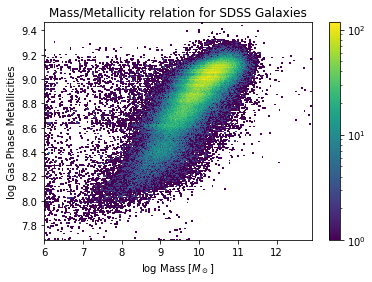

In [11]:
plot_mass_vs_metal(masses,metallicities)

When you run your function, you should get an image identical to the one I have above. As we can see, the gas phase metallicity of a galaxy (that is, it's composition in terms of elements) has a positive correlation with the log Mass. However, maybe this is not quite a direct relation as we might think. We also pulled in Star Formation Rates. Perhaps those are also correlated? Fill in the functions below to make the histograms for SFR v metallicity and SFR v mass. 

In [12]:
def plot_sfr_metal(sfrs,metallicities):
    plt.hist2d(sfrs, metallicities, bins=300, norm=LogNorm())
    plt.title('SFR/Metallicity relation for SDSS Galaxies')
    plt.colorbar()
    plt.xlabel(r'log SFR')
    plt.ylabel(r'log Gas Phase Metallicities')
    plt.show()
def plot_mass_sfr(masses=masses,sfrs=sfrs):
    plt.hist2d(masses, sfrs, bins=300, norm=LogNorm())
    plt.title('Mass/SFR relation for SDSS Galaxies')
    plt.colorbar()
    plt.xlabel(r'log Mass')
    plt.ylabel(r'log SFR')
    plt.show()

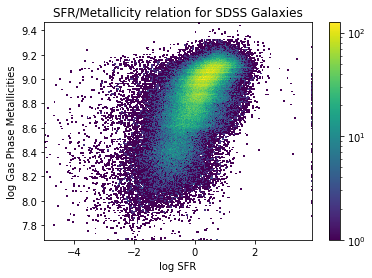

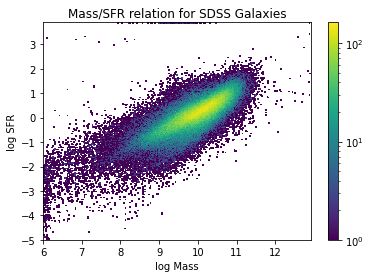

In [13]:
plot_sfr_metal(sfrs,metallicities)
plot_mass_sfr()

Oh dear. It seems like SFR correlates positively with mass, and metallicity correlates positively with SFR. We need to tease out which of these things are actually correlated, and which only look correlated because they depend on something else which is correlated. 

One way we can do this is to take slices of one variable. For example, if metallicity truly does depend on mass, then for all galaxies of a single mass, the correlation should dissapear. We can do such a check for all three of our variables- taking slices of single SFR, metallicity, and mass, and see for which the positive correlation dissapears. 

In the space below, write 3 functions, which will bin your data by mass, metallicity, and sfr slices. In theory we would select multiple single slices (choosing a specific value), but in practice our bins will have to have a certain width. To make things easier, I have looked at the data and created a bins array for each function- see if you can figure out how it works (look at the bounds on the graphs above and the behavior of linspace). 

In [14]:
def mass_bins(masses):
    bins = np.linspace(7,12,10)
    binned_masses = []
    binned_sfrs = []
    binned_z = []
    for i in range(len(bins)-1): #why -1?
        mass_indices = np.where((masses > bins[i]) & (masses < bins[i+1]))                      #check "where" masses are > left edge of bin and < right edge of bin
        mass_indices = np.array(mass_indices)
        
        masses_needed = masses[mass_indices]                   #index masses for the indices found above
        sfr_needed = sfrs[mass_indices]                        #ditto for sfrs 
        z_needed = metallicities[mass_indices]                          #ditto for metallicities
        
        binned_masses.append(masses_needed)
        binned_sfrs.append(sfr_needed)
        binned_z.append(z_needed)
    return binned_masses, binned_sfrs, binned_z

def sfr_bins(sfrs):
    bins = np.linspace(-2,2,10)
    binned_masses = []
    binned_sfrs = []
    binned_z = []
    for i in range(len(bins)-1):
        sfr_indices = np.where((sfrs > bins[i]) & (sfrs < bins[i+1]))
        to_choose = np.array(sfr_indices)
        
        masses_needed = masses[sfr_indices]                 #same process as above
        sfr_needed = sfrs[sfr_indices] 
        z_needed = metallicities[sfr_indices] 
        
        binned_masses.append(masses_needed)
        binned_sfrs.append(sfr_needed)
        binned_z.append(z_needed)
    return binned_masses, binned_sfrs, binned_z

def z_bins(metallicities):
    bins = np.linspace(8,9.5,10)
    binned_masses = []
    binned_sfrs = []
    binned_z = []
    for i in range(len(bins)-1):
        z_indices = np.where((metallicities > bins[i]) & (metallicities < bins[i+1]))
        to_choose = np.array(z_indices)
        
        masses_needed = masses[z_indices]                #and once more (but for z)
        sfr_needed = sfrs[z_indices] 
        z_needed = metallicities[z_indices]  
        
        binned_masses.append(masses_needed)
        binned_sfrs.append(sfr_needed)
        binned_z.append(z_needed)
    return binned_masses, binned_sfrs, binned_z

Lastly, let's write some simple functions to plot up all the sliced data: (This time use 100 bins since there is less data per plot)

In [15]:
def plot_mbins(masses=masses):
    m,s,z = mass_bins(masses)
    for i in range(len(m)):
        plt.hist2d(s[i], z[i], bins=100, norm=LogNorm())                   #2d histogram, think about what to index here
        plt.xlabel('Log SFR')
        plt.ylabel('Log Metallicity')
        plt.colorbar()
        plt.figure()
    plt.show()
    return
    
def plot_sfrbins(sfrs=sfrs):
    m,s,z = sfr_bins(sfrs)
    for i in range(len(m)):
        plt.hist2d(m[i], z[i], bins=100, norm=LogNorm())                   #2d histogram, think about what to index here
        plt.xlabel('Log Mass')
        plt.ylabel('Log Metallicity')
        plt.colorbar()
        plt.figure()
    plt.show()
    return

def plot_zbins(metallicities=metallicities):
    m,s,z = z_bins(metallicities)
    for i in range(len(m)):
        plt.hist2d(m[i], s[i], bins=100, norm=LogNorm())                    #2d histogram, think about what to index here
        plt.xlabel('Log Mass')
        plt.ylabel('Log SFR')
        plt.colorbar()
        plt.figure()
    plt.show()
    return

As a final step, lets run our functions below, and see what we get: 

ValueError: too many values to unpack (expected 2)

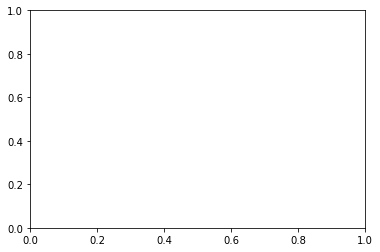

In [16]:
plot_mbins()

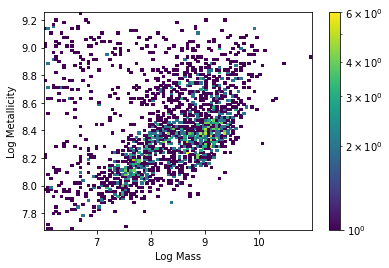

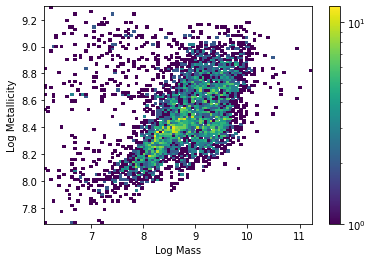

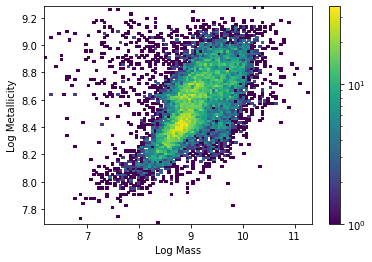

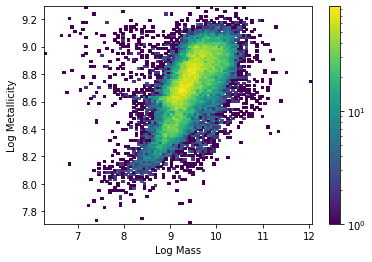

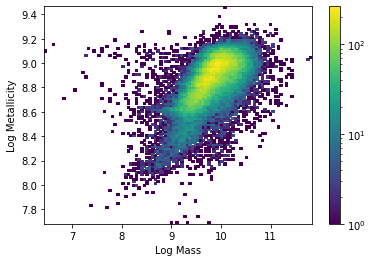

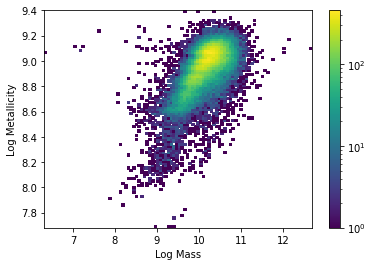

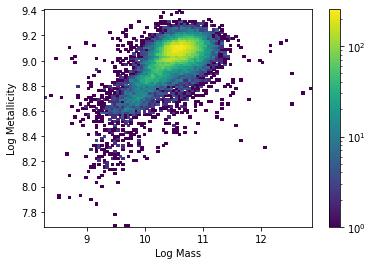

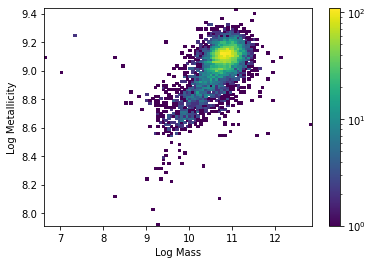

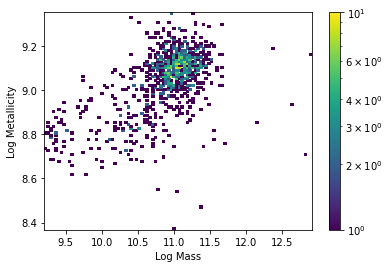

<Figure size 432x288 with 0 Axes>

In [17]:
plot_sfrbins()

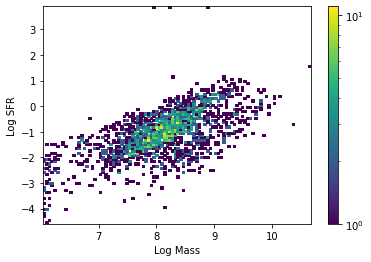

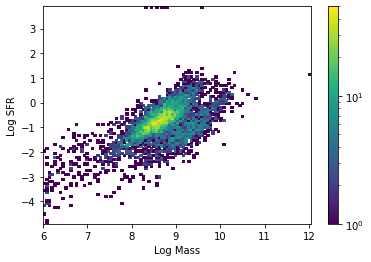

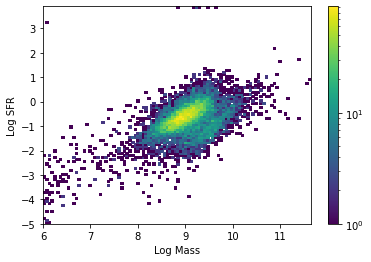

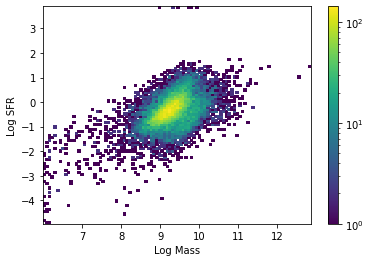

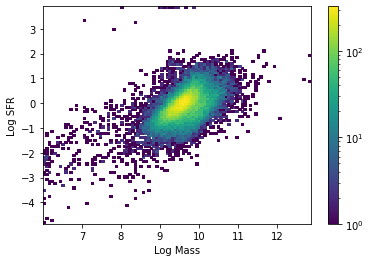

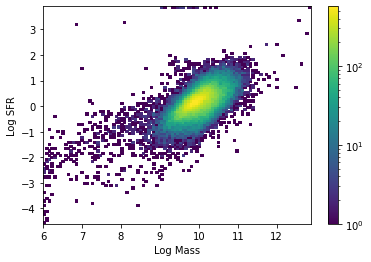

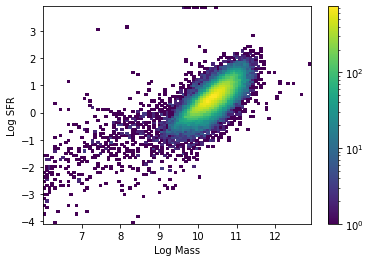

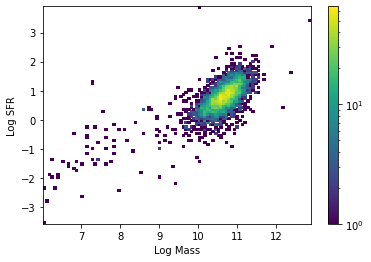

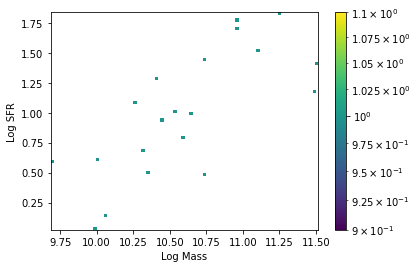

<Figure size 432x288 with 0 Axes>

In [18]:
plot_zbins()

As we can see, the relationship between SFR and metallicity disappears at a single mass slice (the first ten plots). Thus, SFR and metallicity are not truly correlated, but only appear so when all masses are included because each depends on mass (which can be seen in the second and third set of plots, where for single slice in metallicity, the SFR/mass relation still exists, and for single slices in SFR, the mass/metallicity relation still exists. 

Congrats! You made it to the end of the tutorial. I hope you enjoyed it, practiced a little python, and learned something about galaxy properties. As always, feel free to contact me (post an issue on the github http://github.com/prappleizer/prappleizer.github.io ) if anything was messed up, confusing, or poorly explained.